# Введение в глубинное обучение, ФКН ВШЭ

# Практическое задание 2. Рекуррентные Нейронные Сети

## Общая информация
Дата выдачи: 09.02.2021

Мягкий дедлайн: **03.03.2021 00:59 MSK**

Жёсткий дедлайн: **06.03.2021 00:59 MSK**

Штраф за сдачу после мягкого дедлайна: **1 балл в сутки.**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Система оценивания работы находится в конце этого ноутбука.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).


## Формат сдачи
Задания сдаются семинаристу на почту. Посылка должна содержать:
* Ноутбук homework-practice-02-Username.ipynb

Username — ваша фамилия на латинице

## 0. Подготовка данных

Данные представляют собой корпус текстов с 4-мя категориями. Ваша задача - написать классификатор для этих данных, определяющий, к какой из категорий относится текст.

In [ ]:
!pip install navec
!pip install tokenizers
import keras
import numpy as np
import pandas as pd
from navec import Navec
import tensorflow as tf
from random import sample
import matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Add, Multiply, Dense, Activation, Embedding, Concatenate, Bidirectional, Dropout, Conv1D, MaxPooling1D, Input, GRU, BatchNormalization
from os import listdir
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

     |████████████████████████████████| 3.2MB 4.0MB/s 


In [ ]:
df_train = pd.read_csv('./train.csv', engine='python')
df_train.head()

,text,source
0,Российская сборная лидирует по итогам командно...,mchsgov
1,#СоветМЧС #МЧС #МЧСРОССИИ,mchsgov
2,Инспекторы ГИБДД Москвы приняли участие во Все...,mospolice
3,В Главную Военно-Морскую Базу БФ в г.Балтийск ...,mil
4,Обвиняемые в хищении денежных средств у 32 пож...,mospolice


In [ ]:
# hyperparameters

vocab_size = 750
max_len = 500
global_batch_size = 64
padding = 'pre'
truncating = 'post'
oov_token = '<OOV>'
iterations = 5000

## 1. Предобработка данных (1 балл)

В этом задании вам предстоит провести предобработку данных. Баллы ставятся следующим образом:

* Привести все тексты к одной длине, заменить слова/токены на числа, факторизовать целевую переменную и т.д.

* Использовать токенизатор, который разбил бы все слова на токены (подробнее https://github.com/huggingface/tokenizers).

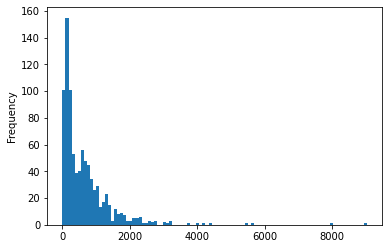

In [ ]:
df_train.text.str.len().plot.hist(bins=100)
df_train = df_train.dropna()

In [ ]:
le = preprocessing.LabelEncoder()
df_train['source'] = le.fit_transform(df_train.source.values)

num_classes = df_train.source.nunique()

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df_train.text)

word_index = tokenizer.word_index
print(list(word_index)[:vocab_size])

sequences = tokenizer.texts_to_sequences(df_train.text)

['<OOV>', 'br', 'в', 'и', 'на', 'по', 'с', 'россии', 'мвд', 'из', 'для', '–', 'а', 'мчс', 'что', 'не', 'г', 'к', 'москве', 'о', 'полиции', 'за', 'полиция', 'также', 'от', 'петровка38', 'года', 'ru', 'гу', 'до', 'news', 'www', 'при', 'новости', 'мчсроссии', 'сотрудники', 'item', 'http', 'минобороны', 'как', 'время', 'или', 'увд', 'более', 'почты', 'https', 'мвдроссии', 'рф', 'управления', 'москвы', 'это', 'их', 'году', 'его', 'во', 'мы', 'mchs', 'ходе', 'gov', 'службы', 'российской', 'все', 'у', 'dop', 'info', 'smi', '1', 'области', 'но', 'он', 'безопасности', 'участие', 'которые', 'было', 'будет', 'день', 'были', 'почтароссии', 'был', 'сегодня', 'вы', 'задержали', 'под', '2', 'со', 'лет', 'всех', 'федерации', 'связи', 'только', 'почта', 'можно', 'почтовых', 'после', 'сотрудников', 'обороны', 'работы', 'начальник', '—', 'чтобы', 'дел', 'том', 'внутренних', '00', 'генерал', 'police', 'который', 'полицейские', 'тысяч', 'дня', 'военного', 'рамках', 'полицияроссии', '8', 'mvdrussia', 'вам',

In [ ]:
x = np.array(pad_sequences(sequences, maxlen=max_len, padding=padding, truncating=truncating))
y = np.array(df_train['source'])
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, stratify=y)

## 2. LSTM-сеть (4 балла)

В этом задании вам предстоит написать LSTM сеть __вручную__ (то есть без использования стандартных реализаций из keras / torch / tensorflow). Сама архитектура отлично расписана здесь: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
keras.backend.clear_session()
# s.close()
s = tf.Session()

In [ ]:
mem_size = 32
emb_size = 16

get_embed_x = Embedding(vocab_size, emb_size)
get_concat = Concatenate()
get_forget = Dense(mem_size, activation='sigmoid')
get_forgotten_mem = Multiply()
get_in_gate = Dense(mem_size, activation='sigmoid')
get_candidate = Dense(mem_size, activation='tanh')
get_candidate_gated = Multiply()
get_next_c = Add()
get_out_gate = Dense(mem_size, activation='sigmoid')
get_c_to_h = Activation('tanh')
get_next_h = Multiply()
get_pred_probas = Dense(4, activation='softmax')

In [ ]:
def lstm_one_step(embed_x, h_t, c_t):
    
    concat = get_concat([embed_x, h_t])
    forget = get_forget(concat)
    in_gate = get_in_gate(concat)
    candidate = get_candidate(concat)
    out_gate = get_out_gate(concat)
    forgotten_mem = get_forgotten_mem([forget, c_t])
    candidate_gated = get_candidate_gated([candidate, in_gate])
    next_c = get_next_c([forgotten_mem, candidate_gated])
    c_to_h = get_c_to_h(next_c)
    next_h = get_next_h([out_gate, c_to_h])  
    
    return next_c, next_h

In [ ]:
input_sequence = tf.placeholder(tf.int32, (None, max_len))
targets = tf.placeholder(tf.int32, (None))
batch_size = tf.shape(input_sequence)[0]
prev_h = tf.random.normal([batch_size, mem_size], 0, 1) 
prev_c = tf.random_normal([batch_size, mem_size], 0, 1)

for t in range(max_len):
    x_t = input_sequence[:, t]
    embed_x = get_embed_x(x_t)
    
    concat = get_concat([embed_x, prev_h])
    forget = get_forget(concat)
    in_gate = get_in_gate(concat)
    candidate = get_candidate(concat)
    out_gate = get_out_gate(concat)
    forgotten_mem = get_forgotten_mem([forget, prev_c])
    candidate_gated = get_candidate_gated([candidate, in_gate])
    next_c = get_next_c([forgotten_mem, candidate_gated])
    c_to_h = get_c_to_h(next_c)

    next_h = get_next_h([out_gate, c_to_h])  
    # next_c, next_h = lstm_one_step(embed_x, prev_h, prev_c)
    
    prev_h = next_h
    prev_c = next_c

pred_probas = get_pred_probas(prev_h)
answers_matrix = tf.one_hot(targets, num_classes)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(answers_matrix, pred_probas))

optimize = tf.train.AdamOptimizer().minimize(loss)

## 3. Модель

В этом задании вам предстоит объединить вашу сеть с несколькими другими слоями для создания итоговой модели классификатора (можно начать с самой базовой архитектуры, слой эмбеддингов - LSTM - выходной слой).

99 / 5000

 1.2068787 


 1.1958213 

199 / 5000

 0.6509264 


 0.65073746 

299 / 5000

 0.36651504 


 0.37891302 

399 / 5000

 0.28413865 


 0.296063 

499 / 5000

 0.23188351 


 0.25033826 

599 / 5000

 0.23054117 


 0.25823748 

699 / 5000

 0.22001852 


 0.264714 

799 / 5000

 0.1511108 


 0.1879162 

899 / 5000

 0.15832876 


 0.18638998 

999 / 5000

 0.17537594 


 0.19630139 

1099 / 5000

 0.13299572 


 0.16234274 

1199 / 5000

 0.1319397 


 0.16734803 

1299 / 5000

 0.10486655 


 0.1475569 

1399 / 5000

 0.109332144 


 0.14678116 

1499 / 5000

 0.099130906 


 0.15295672 

1599 / 5000

 0.12456597 


 0.15131652 

1699 / 5000

 0.12931229 


 0.17034608 

1799 / 5000

 0.09368777 


 0.13548876 

1899 / 5000

 0.18217549 


 0.22939283 

1999 / 5000

 0.22969203 


 0.26969838 

2099 / 5000

 0.14478105 


 0.18802366 

2199 / 5000

 0.1136214 


 0.1476744 

2299 / 5000

 0.09840377 


 0.13616516 

2399 / 5000

 0.09179474 


 0.13081233 

2499 / 5000

 

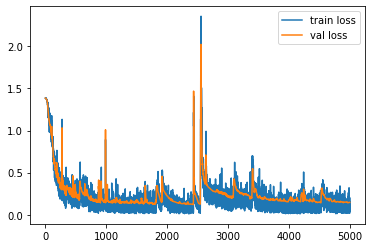

In [ ]:
s.run(tf.global_variables_initializer())

history = []
history_val = []

for i in range(iterations):
    idx = np.random.randint(x_train.shape[0], size=global_batch_size)
    x_batch = x_train[idx, :]
    y_batch = y_train[idx]
    # print(x_batch)
    # print(y_batch.shape)
    loss_i, _ = s.run([loss, optimize], {input_sequence: x_batch, targets: y_batch})
    val_res = s.run(loss, {input_sequence: x_val, targets: y_val})
    # for i in range(len(res)):
    #     print(loc[i], ':')
    #     print(res[i], '\n\n\n')

    history.append(loss_i)
    history_val.append(val_res)
    
    if (i + 1) % 100 == 0:
        # clear_output(True)
        print(i, "/", iterations)
        print('\n', np.array(history[-100:]).mean(), '\n')
        print('\n', np.array(history_val[-100:]).mean(), '\n')

plt.plot(history, label='train loss')
plt.plot(history_val, label='val loss')
plt.legend()
plt.show()


## 4. Обучение модели.

Обученную модель примените для получения предсказаний на Kaggle. Баллы за задания из ноутбука (максимум 5) ставятся в случае, если модель корректно отработала, и вы смогли успешно отправить посылку на Kaggle.

In [ ]:
df_test = pd.read_csv('./test.csv', engine='python', skip_blank_lines=False)
df_test = df_test.fillna('')

print(df_test.shape)
print(df_test.head(10))

print(df_test.text.dtype)

test_sequences = tokenizer.texts_to_sequences(df_test.text)
x_test = np.array(pad_sequences(test_sequences, maxlen=max_len, padding=padding, truncating=truncating))


(1744, 1)
                                                text
0  На полигоне «Погоново» Воронежской области про...
1  #БудниМЧС #МЧС #МЧСРОССИИ <br><br>Пожарные тра...
2  Друзья, напоминаем вам, что завтра единый день...
3  Настольная игра: "Королевская почта"<br><br>По...
4  Миллиарды писем разносят по почтовым ящикам на...
5  Знали ли вы, что техника нанесения «зубцов» на...
6  #МЧС #МЧСРОССИИ <br><br>В новом выпуске #МЧС_1...
7  #БудниМЧС #МЧС #МЧСРОССИИ <br>Казанские огнебо...
8  Бомбардировщик Су-34 на взлете <br> <br>#Миноб...
9  Сегодня в Москве в здании Ленинградского вокза...
object


NameError: ignored

In [ ]:
test_res = s.run(pred_probas, {input_sequence: x_test})

test_res = np.array(test_res)

predictions = le.inverse_transform(test_res.argmax(axis=1))

print(predictions[:10])



['mil' 'mchsgov' 'mchsgov' 'russianpost' 'russianpost' 'russianpost'
 'mchsgov' 'mchsgov' 'mil' 'mchsgov']


In [ ]:
res = pd.DataFrame()

res['Id'] = np.arange(df_test.shape[0])
res['Category'] = predictions
print(res.shape)
res.to_csv('submission.csv', index=False)

(1744, 2)


## 5. Нормальная модель для каггла.



In [ ]:
#have to restart the runtime and do the imports again for this one
%tensorflow_version 2.x 

In [ ]:
# hyperparameters

vocab_size = 40000
# max_len = 700
emb_size = 400
padding = 'pre'
truncating = 'pre'
oov_token = '<unk>'

In [ ]:
df_train = pd.read_csv('./train.csv', engine='python')
df_train = df_train.fillna(" ")

num_classes = df_train.source.nunique()

onehot = preprocessing.OneHotEncoder()
y = np.array(df_train.source).reshape(-1, 1)
y = onehot.fit_transform(y).toarray()

In [ ]:
#minor text processing

df_train['text'] = df_train['text'].replace({'<br>': ' <br >'}, regex=True)
df_train['text'] = df_train['text'].str.lower()

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df_train.text)
sequences = tokenizer.texts_to_sequences(df_train.text)

word_index = tokenizer.word_index
print(len(word_index))

x1 = np.array(pad_sequences(sequences))
# x1 = np.array(pad_sequences(sequences, maxlen=max_len, padding=padding, truncating=truncating))

79624


In [ ]:
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

hits = 0
misses = 0

embedding_matrix1 = np.zeros((vocab_size, emb_size))
for word, i in word_index.items():
    if (i >= vocab_size):
        continue
    embedding_vector = navec.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

# Misses are mostly from hashtags. This isn't ideal, as they give us a lot of info, so won't be freezing our embedding layer.

Converted 39997 words (10002 misses)


In [ ]:
checkpoint_path = "training_1/cp.ckpt"

cp1_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model1 = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.25),
    Dense(4, activation='softmax')
])
model1.summary()

model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history1 = model1.fit(x=x1, 
                    y=y, 
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[cp1_callback])

KeyboardInterrupt: ignored

In [ ]:
checkpoint_path = "training_2/cp.ckpt"

cp2_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model2 = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history2 = model2.fit(x=x1, 
                    y=y, 
                    epochs=12,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[cp2_callback])

In [ ]:
checkpoint_path = "training_3/cp.ckpt"

cp3_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model3 = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, embeddings_initializer=keras.initializers.Constant(embedding_matrix1, mask_zero=True),
    Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

model3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history3 = model3.fit(x=x1, 
                    y=y, 
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[cp3_callback])

Epoch 1/10
 2/69 [..............................] - ETA: 10:15 - loss: 1.4184 - accuracy: 0.2305

KeyboardInterrupt: ignored

In [ ]:
checkpoint_path = "training_4/cp.ckpt"

cp4_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model4 = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, embeddings_initializer=keras.initializers.Constant(embedding_matrix1), mask_zero=True),
    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(tf.keras.layers.GRU(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(128)),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model4.summary()

model4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history4 = model4.fit(x=x1, 
                    y=y, 
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[cp4_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          48032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         124416    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense (Dense)                (None, 256)               6

KeyboardInterrupt: ignored

In [ ]:
checkpoint_path = "training_5/cp.ckpt"

cp5_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model5 = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True),
    Dropout(0.7),
    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    # Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True, dropout=0.1)),
    Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.2, recurrent_dropout=0.1)),
    Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2)),
    # Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model5.summary()

model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Nadam(),
              metrics=['accuracy'])
history5 = model5.fit(x=x1, 
                    y=y, 
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[cp5_callback])

SyntaxError: ignored

In [ ]:
tokenizer = Tokenizer(BPE(unk_token="<UNK>"))
trainer = BpeTrainer(special_tokens=["[PAD]", "<UNK>", "[CLS]", "[SEP]", "[MASK]"])
tokenizer.pre_tokenizer = Whitespace()

tokenizer.train_from_iterator(df_train.text.to_numpy(), trainer)

# temp = pd.read_csv('news.csv', engine='python')
# tokenizer.train_from_iterator(temp.text.to_numpy(), trainer)

# files_path = ["Interfax/texts/" + x for x in listdir("Interfax/texts")]
# tokenizer.train(files_path, trainer)

tokenizer.enable_padding(direction='left', length=max_len)
tokenizer.enable_truncation(max_length=max_len)

encodings = tokenizer.encode_batch(df_train.text)

word_index = tokenizer.get_vocab()

vocab_size = tokenizer.get_vocab_size()

In [ ]:
hits = 0
misses = 0

embedding_matrix2 = np.zeros((vocab_size, emb_size))
for word, i in word_index.items():
    if (i >= vocab_size):
        continue
    embedding_vector = navec.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix2[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16358 words (13642 misses)


In [ ]:
x2 = np.empty(shape=(len(encodings), len(encodings[0].ids)), dtype='int32')
for i, enc in enumerate(encodings):
    x2[i] = enc.ids

In [ ]:
df_test = pd.read_csv('./test.csv', engine='python', skip_blank_lines=False)
df_test = df_test.fillna('')

test_sequences = tokenizer.texts_to_sequences(df_test.text)

x_test = np.array(pad_sequences(test_sequences))

y_test = model5.predict(x_test)

print(y_test)

pred = (y_test == y_test.max(axis=1, keepdims=1)).astype(int)
pred = onehot.inverse_transform(pred)
print(pred[:10])

res = pd.DataFrame()

res['Id'] = np.arange(df_test.shape[0])
res['Category'] = pred
print(res.shape)
res.to_csv('submission.csv', index=False)

text    12
dtype: int64
[[1.25752777e-04 9.99749124e-01 4.23836609e-05 8.27834374e-05]
 [9.91665304e-01 7.53057981e-03 4.68785467e-04 3.35310935e-04]
 [1.09071089e-02 6.24703767e-04 3.02390102e-03 9.85444248e-01]
 ...
 [9.97639894e-01 1.89053454e-03 2.81323853e-04 1.88373786e-04]
 [3.87404689e-05 9.99915957e-01 1.76410995e-05 2.76189767e-05]
 [5.26255404e-04 3.22388660e-05 9.88058150e-01 1.13832485e-02]]
[['mil']
 ['mchsgov']
 ['russianpost']
 ['russianpost']
 ['russianpost']
 ['russianpost']
 ['mchsgov']
 ['mchsgov']
 ['mil']
 ['mchsgov']]
(1744, 2)


## Система оценивания домашнего задания

В домашнем задании две смысловые части:

1. выполнение заданий из ноутбука --- **5 баллов**

2. создание архитектуры сети, дающей как можно лучшее качество на Kaggle --- **5 баллов (+5 бонусных баллов)**. Эта архитектура не обязана содержать написанный вами собственноручно LSTM слой.


#### Оценивание результатов Kaggle:

Public Leaderboard содержит только 30% тестовых данных. Private leaderboard вычисляется по оставшимся 70% тестовых данных, так что после завершения соревнования Ваша позиция на leaderboard-е может поменяться.

Основные баллы (максимум 5) вычисляются по следующему правилу **по public leaderboard**:

* val_accuracy $>$ baseline (0.96367): 1 балл

* val_accuracy $\geq$ 0.968: 2 балла

* val_accuracy $\geq$ 0.972: 3 балла

* val_accuracy $\geq$ 0.976: 4 балла

* val_accuracy $\geq$ 0.98: 5 баллов

Бонусные баллы:

Если вы верно выполнили задание с имплементацией LSTM в этом ноутбуке и попали **на private leaderboard**:

* в лучшие 10% среди всех участников соревнования, вы получаете 2 бонусных балла

* в топ-3 среди всех участников соревнования, вы получаете 5 бонусных баллов.

**Максимальный суммарный балл за домашнее задание** - 15.

Финальный комментарий - на последнее задание (с кагглом) было убито двое суток, только чтобы получить один балл. Начиная с простых моделей, я постепенно поднимал планку безумства. Что если использовать натреннированные токенайзеры из Tokenizers? И натренировать их на опенсурсных корпусах новостей? Может, можно использовать предобученные эмбеддинги? Нашел и корпус тайги для этого. Может, к этому можно подключить BERT, и уже на его основе писать классификацию? Что если наложить несколько слоев CNN после эмбеддинга для анализа групп токенов, а не каждого по отдельности? В целом, импорты в начале дают довольно хорошую картину безысходных попыток что-то сделать.

Ничто из этих безумных идей, конечно же, не помогло. Не помогло и аккуратное регулирование более незначительных деталей, вроде регуляризации на слоях FC, дропаутов, обычных и рекуррентных, наслаивание RNN, GRU, LSTM. 

Казино было непристрастно, и отказывалось выдавать val_accuracy больше 0.972. Да и даже 0.972 на местном val превращались в 0.96558 на лидерборде.

Очень странно видеть подобные задания после серии дз в виде "мы тут все за тебя написали, но тебе дано важное задание - напечатать результат наших вычислений" на курсере. Я понятия не имею, что я делаю, дергаю рубильники в надежде, что что-то может быть поменяется и казино смилуется, подобно мартышке, которую посадили в реактивный истребитель с завязанными глазами.

Единственное, чему меня это дз толком научило - это тому, сколько можно продержаться на колабе без приглушения скорости, как это приглушение можно обойти, и когда его можно обойти, а когда нельзя.